# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The business requirement here is to leverage used car sales data to better understand purchasing decisions of customers. We should examine all dimensions in the data to see which features have an impact in determining how much a customer will pay for a car.

We can use correlation and linear models to measure feature importance. Linear regression coefficients will suggest the magnitude of the relationship, and once we have this we can then inform the business on which levers they can manipulate to sell more cars or sell cars at a higher price. I will use a number of techniques in linear modeling to find the most accurate models (Sequential Feature Selection, Polynomial Features, Grid Search), and will apply regularization (L1, L2) if we want to limit the magnitude of coefficients.

If there are no obvious relationships in the data, we can try K-means clustering to try and identify similar pricing dynamics among certain groups of cars. If we have a large number of dimensions in the raw data, we can use PCA to reduce dimensionality while maintaining most of the variation in the data set.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. Examine all column and column types. Check how many missing values are in the data set.
2. How many unique values in each column? Are there ordinal string columns?
3. Are there levels to the data? Geographic, time, etc.
4. Chart data to view general trends and relationships (pairplot)
5. Make correlation matrix to see related fields

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
def getPctMissing(df):
  return (df.isna().sum()/df.shape[0]*100).sort_values(ascending=False).round(1)

In [3]:
df = pd.read_csv('data/vehicles.csv')

In [4]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

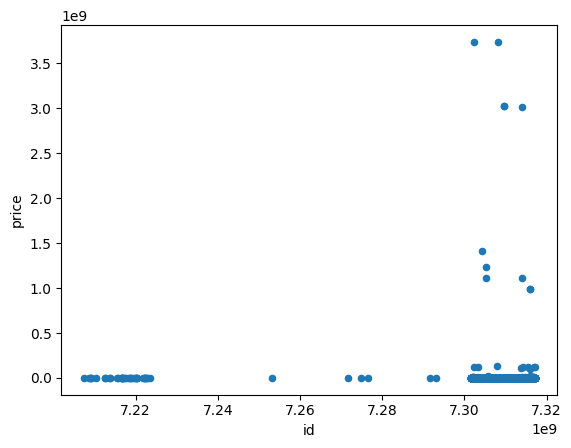

In [6]:
# drop id and VIN since these have no impact on price
df.plot(kind='scatter', x='id', y='price')
df = df.drop(columns=['id','VIN'])

<Axes: ylabel='Frequency'>

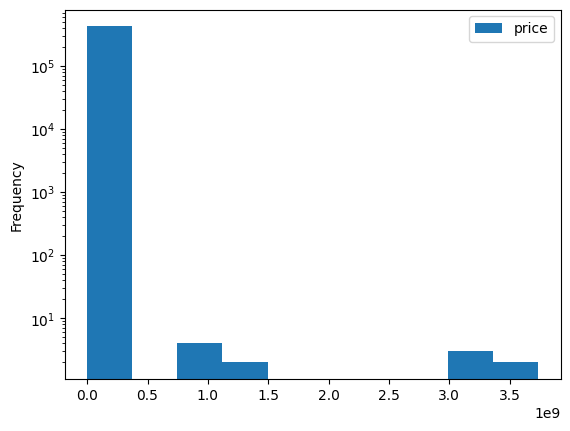

In [7]:
# Inspect distribution of price. Any outliers or strange trends?
# Use log scale to see the outliers around 3 and 1 e^9
df[['price']].plot(kind='hist', logy=True)

In [8]:
# There are outliers with prices of over $1b. Limiting to below $100k is reasonable
# given anything above that in this data set is extremely rare. Our model will not be good
# at predicting in that price region so I'd just limit training data to 100k.
df.query('price < 100000').sort_values('price', ascending=False).head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
77605,denver,99999,2015.0,jeep,wrangler unlimited rubicon,NaN,8 cylinders,gas,15944.0,clean,automatic,4wd,NaN,SUV,NaN,co
255553,north jersey,99999,2021.0,chevrolet,corvette,new,8 cylinders,gas,1.0,clean,automatic,rwd,NaN,NaN,black,nj
44134,palm springs,99999,1997.0,ferrari,f355 spider,excellent,8 cylinders,gas,22000.0,clean,manual,NaN,NaN,convertible,NaN,ca
44389,palm springs,99999,1997.0,ferrari,f355 spider,excellent,8 cylinders,gas,22000.0,clean,manual,NaN,NaN,convertible,NaN,ca
246133,scottsbluff / panhandle,99999,2020.0,ford,f-150 shelby edition,excellent,8 cylinders,gas,9600.0,clean,automatic,4wd,NaN,pickup,blue,ne


In [9]:
# almost 33k rows where price = 0, a minimum price of $1000 will probably drop a lot of incorrect data and is a reasonable minimum price of a pricing model
df.query('price < 1000').head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
10,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
11,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
12,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
13,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
14,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx


<Axes: ylabel='Frequency'>

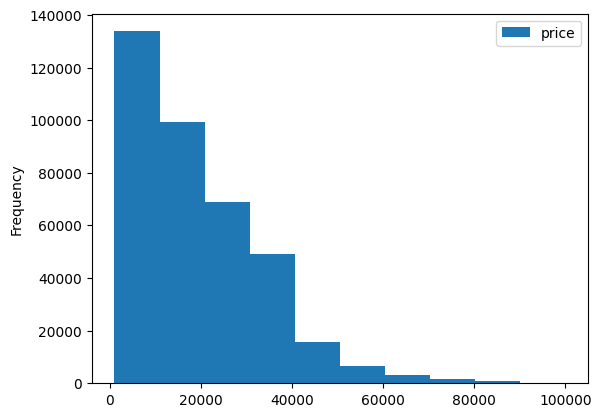

In [10]:
# This looks like a more reasonable price distribution. I think anything above
# $100k is more of a special sale and not something that needs to be modeled.
df[['price']].query('price < 100000 and price > 1000').plot(kind='hist')

In [11]:
# Limit data to between $1k and $100k
df = df.query('price >= 1000 and price <= 100000')

In [12]:
# Column % missing values
# Quite a few columns are over 20% null. For the others maybe we can drop rows
getPctMissing(df)

size            71.8
cylinders       40.8
condition       37.7
drive           30.3
paint_color     28.6
type            21.3
manufacturer     3.9
title_status     1.7
model            1.2
fuel             0.7
odometer         0.5
transmission     0.5
year             0.3
region           0.0
price            0.0
state            0.0
dtype: float64

In [13]:
# size is 72% missing, and the categories don't look informative anyway
# drop this column
df.groupby('size', dropna=False)['price'].mean()
df = df.drop(columns='size')

In [14]:
# cylinders is 41% missing. I checked a couple correlations and did
# not see anything we could use to impute missing values. Filling in
# a mean or some stat would create too much bias given it's 41% of the data.
df.value_counts('cylinders', dropna=False)
df = df.drop(columns='cylinders')

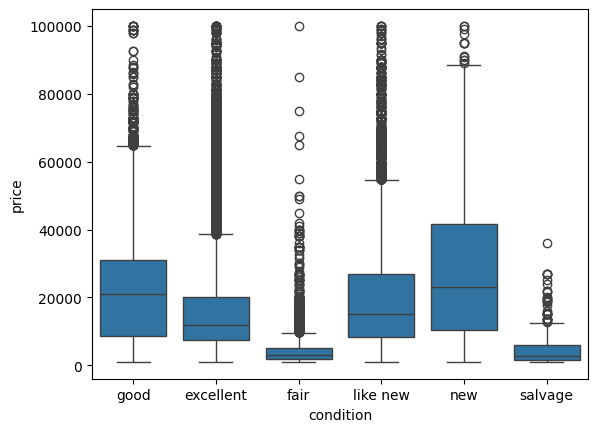

In [15]:
# The condition does not look like it has a strong effect on price. They are
# ordinal (from salvage to new) but the pricing is not linear. New, like new, good,
# and excellent are all very close in mean price. 

# Given this is 41% missing, I will drop this column
sns.boxplot(df, x='condition',y='price')
df = df.drop(columns='condition')

drive
4wd    115942
NaN    115013
fwd     94794
rwd     54161
Name: count, dtype: int64

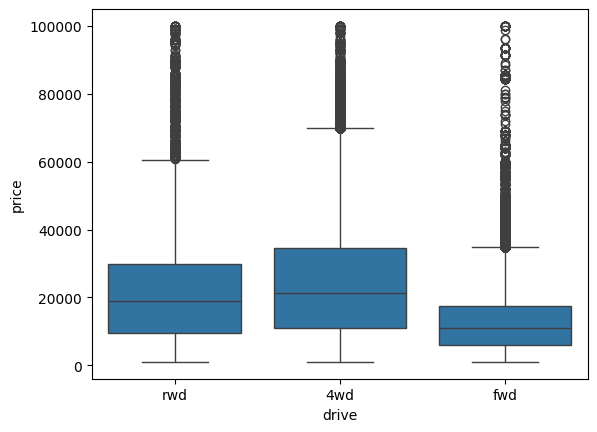

In [16]:
# drive is also largely 30% without a big trend on price. Dropping
display(df.value_counts('drive', dropna=False))
sns.boxplot(df, x='drive', y='price')
df = df.drop(columns='drive')

paint_color
NaN       108588
white      71528
black      57489
silver     39300
blue       28866
red        28332
grey       22269
green       6848
custom      6164
brown       6066
yellow      1991
orange      1815
purple       654
Name: count, dtype: int64

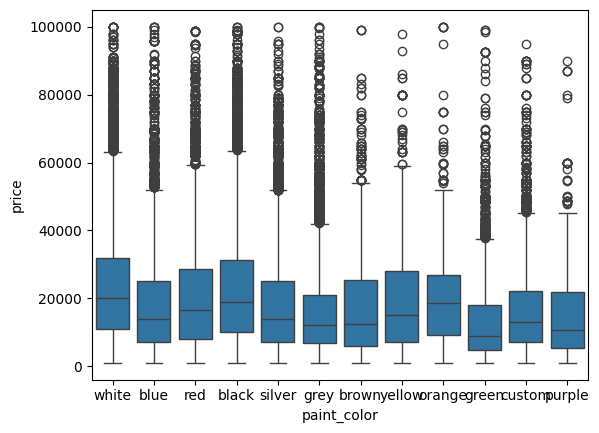

In [17]:
# paint_color is mostly missing and has a lot of values with small frequency
# like purple, organge, yellow. I don't think it's worth adding variation to the model
# predict prices of such rare colors.

# The prices are all similar each with many outliers. Dropping
display(df.value_counts('paint_color', dropna=False))
sns.boxplot(df, x='paint_color', y='price')
df = df.drop(columns='paint_color')

type
NaN            21.340054
sedan          20.375615
SUV            17.896607
pickup         10.807296
truck           7.754468
other           5.139902
coupe           4.621358
hatchback       4.094654
wagon           2.565871
van             2.054171
convertible     1.901240
mini-van        1.173962
offroad         0.153194
bus             0.121608
Name: count, dtype: float64

<Axes: xlabel='type', ylabel='price'>

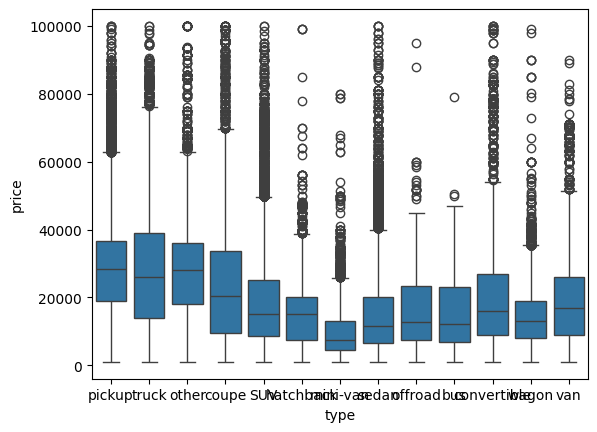

In [18]:
# There is some price variation explained by type, but there are a lot of outliers for
# each type. I think ultimately type will add noise to the model with so many outliers
# so I will drop it.
display(df.value_counts('type', dropna=False)/df.shape[0]*100)
display(sns.boxplot(df, x='type', y='price'))

In [19]:
# There are no strong correlations to other columns, so imputing a type will be difficult.
# Given there is some pricing information
corr = pd.concat([df.select_dtypes('number'), pd.get_dummies(df['type'], dummy_na=True)*1]).corr()
display(corr.style.background_gradient(cmap='coolwarm'))
df = df.drop(columns='type')

,price,year,odometer,SUV,bus,convertible,coupe,hatchback,mini-van,offroad,other,pickup,sedan,truck,van,wagon,nan
price,1.000000,0.365390,-0.197752,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
year,0.365390,1.000000,-0.174354,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
odometer,-0.197752,-0.174354,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
SUV,nan,nan,nan,1.000000,-0.016291,-0.064997,-0.102769,-0.096470,-0.050886,-0.018288,-0.108678,-0.162517,-0.236177,-0.135366,-0.067613,-0.075765,-0.243179
bus,nan,nan,nan,-0.016291,1.000000,-0.004858,-0.007681,-0.007210,-0.003803,-0.001367,-0.008122,-0.012146,-0.017651,-0.010117,-0.005053,-0.005662,-0.018175
convertible,nan,nan,nan,-0.064997,-0.004858,1.000000,-0.030644,-0.028766,-0.015173,-0.005453,-0.032406,-0.048460,-0.070424,-0.040364,-0.020161,-0.022592,-0.072512
coupe,nan,nan,nan,-0.102769,-0.007681,-0.030644,1.000000,-0.045483,-0.023991,-0.008622,-0.051238,-0.076622,-0.111350,-0.063821,-0.031878,-0.035721,-0.114652
hatchback,nan,nan,nan,-0.096470,-0.007210,-0.028766,-0.045483,1.000000,-0.022521,-0.008094,-0.048098,-0.071925,-0.104525,-0.059909,-0.029924,-0.033531,-0.107624
mini-van,nan,nan,nan,-0.050886,-0.003803,-0.015173,-0.023991,-0.022521,1.000000,-0.004269,-0.025370,-0.037939,-0.055135,-0.031601,-0.015784,-0.017687,-0.056769
offroad,nan,nan,nan,-0.018288,-0.001367,-0.005453,-0.008622,-0.008094,-0.004269,1.000000,-0.009118,-0.013635,-0.019815,-0.011357,-0.005673,-0.006356,-0.020402


In [20]:
# remaining columns only largely non-null
getPctMissing(df)

manufacturer    3.9
title_status    1.7
model           1.2
fuel            0.7
odometer        0.5
transmission    0.5
year            0.3
region          0.0
price           0.0
state           0.0
dtype: float64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379910 entries, 0 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        379910 non-null  object 
 1   price         379910 non-null  int64  
 2   year          378746 non-null  float64
 3   manufacturer  364940 non-null  object 
 4   model         375506 non-null  object 
 5   fuel          377319 non-null  object 
 6   odometer      377838 non-null  float64
 7   title_status  373352 non-null  object 
 8   transmission  378100 non-null  object 
 9   state         379910 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 31.9+ MB


<Axes: xlabel='price', ylabel='manufacturer'>

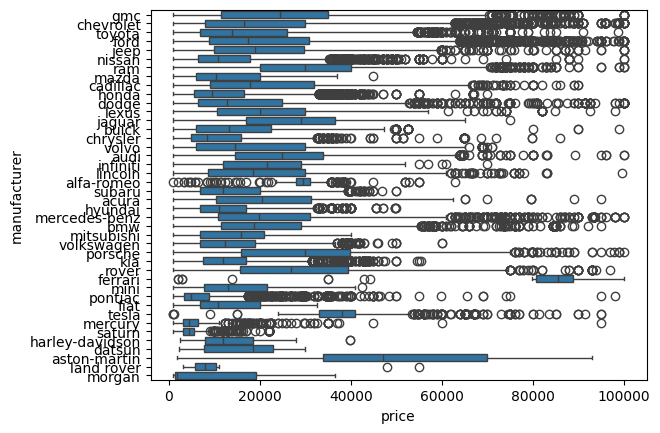

In [22]:
# It looks like manufacturer can be important for some labels
df.value_counts('manufacturer', dropna=False)
sns.boxplot(df, y='manufacturer', x='price')

In [23]:
# data quality of rows with missing manufacturers is low,
# I'm dropping these rows from the data set.
display(df.query('manufacturer.isna()').head(10))
df = df.query('manufacturer.isna() == False')

,region,price,year,manufacturer,model,fuel,odometer,title_status,transmission,state
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
5,hudson valley,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
6,hudson valley,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
7,hudson valley,15995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
8,medford-ashland,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,or
9,erie,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pa


In [24]:
getPctMissing(df)

title_status    1.7
model           1.2
fuel            0.6
odometer        0.5
transmission    0.5
year            0.0
region          0.0
price           0.0
manufacturer    0.0
state           0.0
dtype: float64

title_status
clean         346645
rebuilt         6779
salvage         3499
lien            1325
missing          499
parts only        89
Name: count, dtype: int64

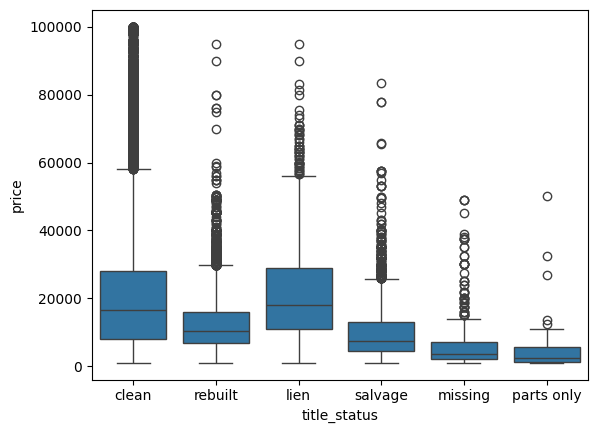

In [25]:
# has variation in price, I will keep title_status
# and impute the most frequent value for the missing values
display(df.value_counts('title_status'))
sns.boxplot(df, x='title_status', y='price')
df.fillna({'title_status': 'clean'}, inplace=True)


In [26]:
getPctMissing(df)

model           1.2
fuel            0.6
odometer        0.5
transmission    0.5
year            0.0
region          0.0
price           0.0
manufacturer    0.0
title_status    0.0
state           0.0
dtype: float64

21733

<Axes: xlabel='model'>

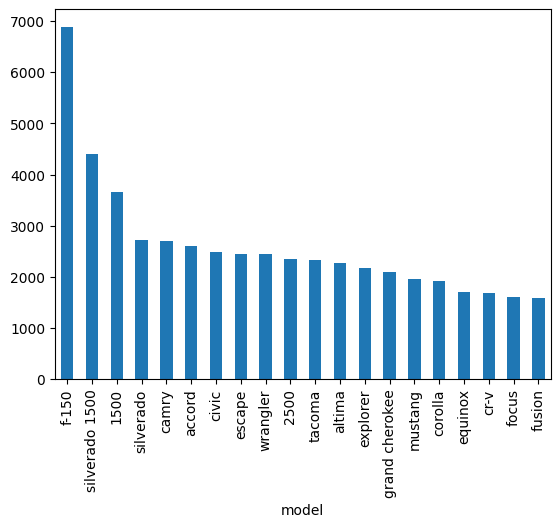

In [27]:
# 21k values in the model column, I don't think I want 21k dummy variables
# in the feature set
display(df.value_counts('model', dropna=False).shape[0])
df.value_counts('model').head(20).plot(kind='bar')

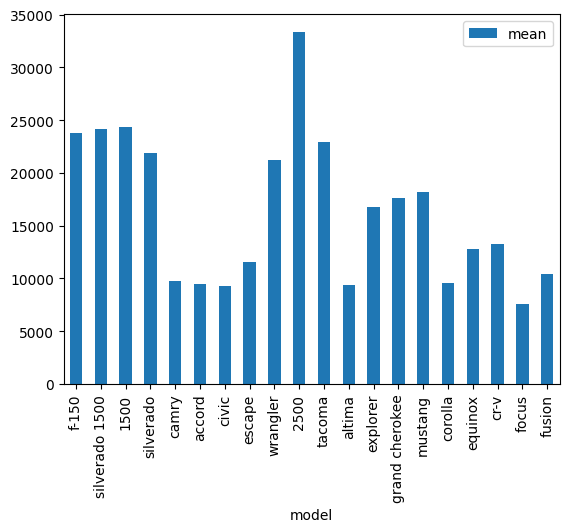

In [28]:
# Columns looks to be of low quality, too many messy values
# Dropping.
df.groupby('model')['price'].agg(['size','mean']).sort_values('size', ascending=False).head(20) \
  .reset_index().plot(kind='bar', x='model', y='mean')
df = df.drop(columns='model')

In [29]:
getPctMissing(df)

fuel            0.6
odometer        0.5
transmission    0.5
year            0.0
region          0.0
price           0.0
manufacturer    0.0
title_status    0.0
state           0.0
dtype: float64

fuel
gas         307932
other        26305
diesel       22345
hybrid        4691
electric      1501
Name: count, dtype: int64

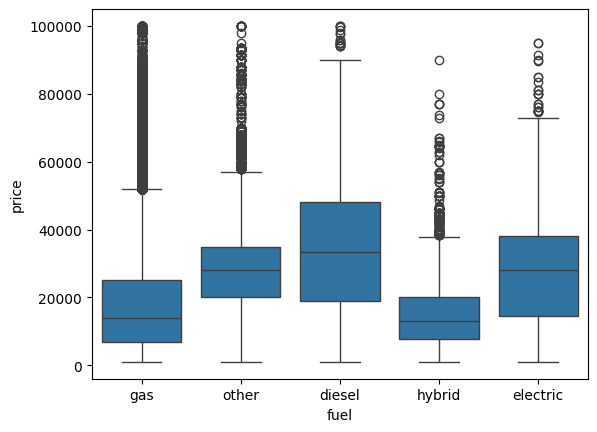

In [30]:
# Fair amount of variation across fuel types. Imputing most common value
# for NAs
display(df.value_counts('fuel'))
sns.boxplot(df, x='fuel', y='price')
df.fillna({'fuel':'gas'}, inplace=True)

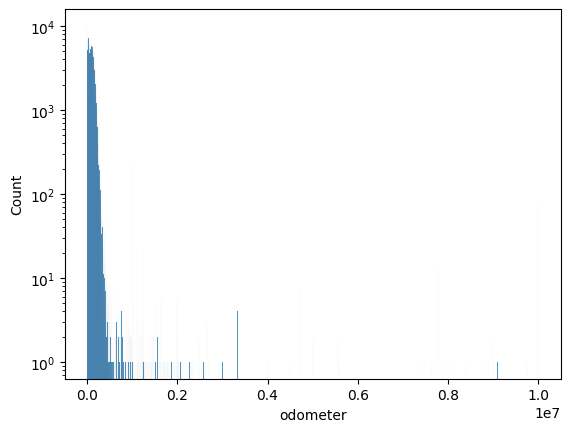

In [31]:
# Looks like there are a lot of extreme outliers above 4,000,000
# This shows poor data quality since the highest odometer reading ever recorded
# is 3m, and I'm sure even over 500k is extremely extremely rare. I will remove any
# records with odometer readings over 1m.
sns.histplot(df, x='odometer').set_yscale('log')
df = df.query('odometer < 500000 or odometer.isna()')

In [32]:
# impute median value for NAs
df.fillna({'odometer': df['odometer'].median()}, inplace=True)

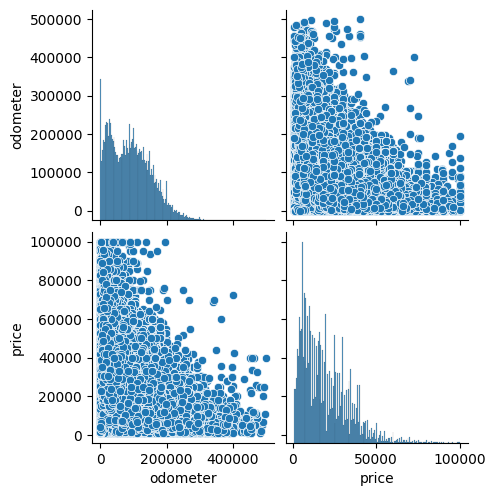

In [33]:
# There's a negative correlation with odometer, as expected
sns.pairplot(df[['odometer','price']])

transmission
automatic    283822
other         58529
manual        20192
NaN            1695
Name: count, dtype: int64

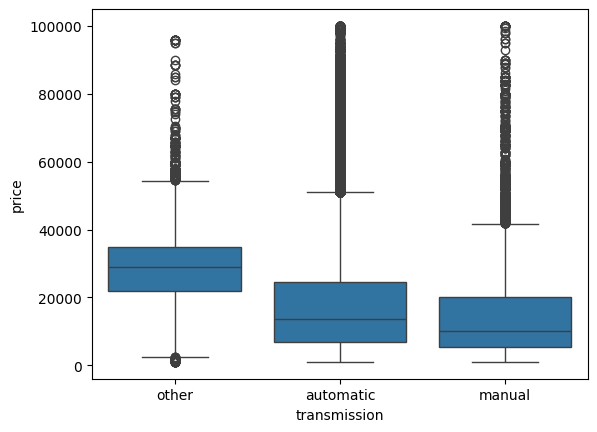

In [34]:
# Very few missing values in transmission, imputing most
# common value
display(df.value_counts('transmission', dropna=False))
sns.boxplot(df, x='transmission', y='price')
df.fillna({'transmission': 'automatic'}, inplace=True)

In [35]:
# Only 4 missing values remain in year. Just drop them.
display(df.isna().sum())
df = df.query('year.isna() == False')

region          0
price           0
year            4
manufacturer    0
fuel            0
odometer        0
title_status    0
transmission    0
state           0
dtype: int64

In [36]:
# Looking at year, some years have very few rows. I will drop
# any year with fewer than 50 cars to reduce variance
yearsToDrop = df.value_counts('year').to_frame().query('count < 50').index.to_list()
df = df.query('year not in @yearsToDrop')

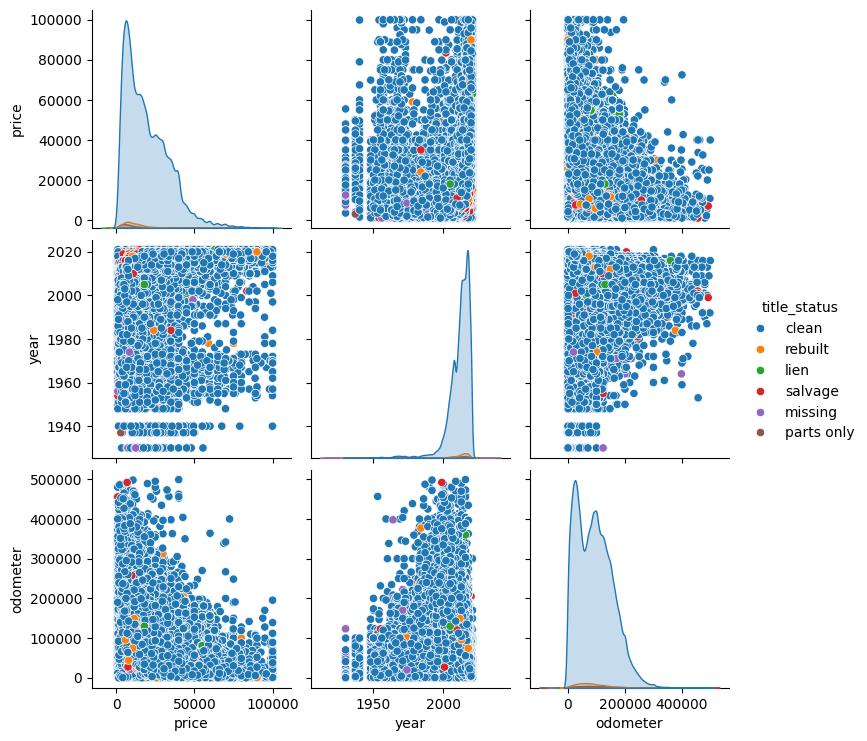

In [37]:
# pairplot of numeric values colord by title_status. nothing super interesting here.
sns.pairplot(df[['price', 'year', 'odometer','title_status']], hue='title_status')

region
columbus               3182
jacksonville           2942
grand rapids           2829
kansas city, MO        2762
nashville              2731
                       ... 
meridian                 16
southwest MS             12
kansas city               8
fort smith, AR            7
west virginia (old)       6
Name: count, Length: 404, dtype: int64

<Axes: >

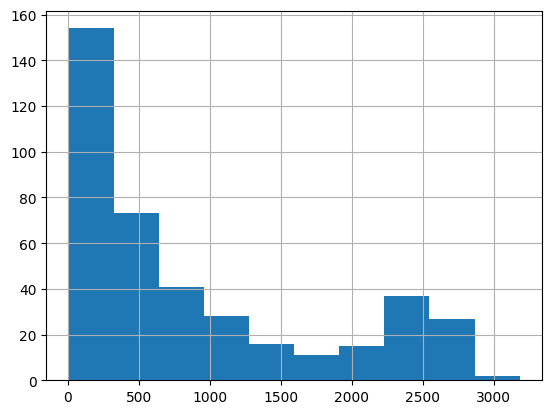

In [38]:
# 404 regions with bimodal distribution of counts
display(df.value_counts('region'))
df.value_counts('region').hist()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

I prefer to explore the data and prepare it at the same time. I progress through the data set cleaning it as I learn about it. All preparation has been done above based on my exploratory findings. This includes:
- Drop identification columns that are not related to price
- Dropping several columns that had high percentage of missing values. I did not see any obvious values to impute and randomly choosing one would have a significant impact on the data.
- Limit the range of some numeric columns by dropping extreme values with few row counts. For prediction, we are not likely to get such extreme values so we should not train the model on these values.
- For columns with some missing values, I imputed the median or the mode of the column.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [39]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector, VarianceThreshold
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer

In [40]:
# Setup training and test sets
trainX, testX, trainY, testY = train_test_split(df.drop(columns='price'), df['price'], train_size=0.7, random_state=420)

In [41]:
trainX.head()

,region,year,manufacturer,fuel,odometer,title_status,transmission,state
187217,boston,2004.0,ford,gas,182000.0,clean,automatic,ma
319280,medford-ashland,2005.0,honda,gas,160000.0,clean,automatic,or
357459,memphis,2014.0,chrysler,gas,129128.0,clean,automatic,tn
288118,akron / canton,2009.0,bmw,gas,98000.0,clean,automatic,oh
119467,treasure coast,2017.0,nissan,gas,13287.0,clean,automatic,fl


In [42]:
# Define pipeline
# I iterated for many hours on this - SequentialFeatureSelector was always too slow to process. When I
# set number of features to be low (under 20), the result was worse than using the full data set. I decided
# to use VarianceThreshold to drop features that were extremely rare or extremely frequent (particularly
# relevant for region and manufacturer OneHotEncoder)
pipeline = Pipeline([
  ('preprocess', make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['region','manufacturer','fuel','title_status','transmission','state']),
    (PolynomialFeatures(include_bias=False), ['year','odometer']))),
  ('varFilter', VarianceThreshold(.01)),
  # Need to use with_mean = False since sparse matrices are generated. Unfortunately this makes
  # coefficient analysis more difficult
  ('scale', StandardScaler(with_mean=False)),
  ('regression', Lasso(tol=.001))
])

# Hyperparameters to use in grid search
parameters = {
  'preprocess__polynomialfeatures__degree': [2,3],
  'regression__alpha': [0.1, 1, 10, 100],
}

# Use cv=3 since we have so many rows and are already fitting a lot of models (2 * 4 models)
# MSE should work well  as a scoring metric
gridSearch = GridSearchCV(pipeline, param_grid=parameters, cv=3, scoring='neg_mean_squared_error')

In [43]:
# Lasso regression gives warnings about convergence. I reduced tol but I'm reluctant
# to increase it too far from the default 0.0001
gridSearch.fit(trainX, trainY)

c:\Users\ryans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7273901918272.882, tolerance: 34364507985.77128
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\ryans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7243470885377.573, tolerance: 34264271463.08478
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\ryans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7266620198259.433, tolerance: 34207298823.492928
  model = cd_fast.sparse_enet_coordinate_descen

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['region',
                                                                          'manufacturer',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'transmission',
                                                                          'state']),
                                                                        ('polynomialfeatures',
                                                                         PolynomialFeatures(include_bias=False),
                                                                         ['year',
                                                                          'odometer'])])),
                                       ('varFilter',
                                        VarianceThreshold(threshold=0.01)),
                                       ('scale',
                                        StandardScaler(with_mean=False)),
                                       ('regression', Lasso(tol=0.001))]),
             param_grid={'preprocess__polynomialfeatures__degree': [2, 3],
                         'regression__alpha': [0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [44]:
results = pd.DataFrame(gridSearch.cv_results_)[['mean_fit_time','param_preprocess__polynomialfeatures__degree',
                                      'param_regression__alpha', 'mean_test_score','rank_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

In [45]:
# The top model includes polynomial degree = 3 with a Lasso alpha parameter of 0.1, but
# the MSE of all models is quite similar. Potentially increasing the degree could improve the model,
# but the grid search takes a long time to run.
results.sort_values('rank_test_score')

,mean_fit_time,param_preprocess__polynomialfeatures__degree,param_regression__alpha,mean_test_score,rank_test_score
4,31.584611,3,0.1,8.607467e+07,1
5,31.273433,3,1.0,8.613519e+07,2
6,36.109570,3,10.0,8.672629e+07,3
1,31.511296,2,1.0,8.705902e+07,4
0,32.262504,2,0.1,8.706162e+07,5
2,10.635607,2,10.0,8.721773e+07,6
3,6.749582,2,100.0,8.801805e+07,7
7,8.049739,3,100.0,8.831352e+07,8


In [46]:
# Check performance on our test set using the best estimator
preds = gridSearch.best_estimator_.predict(testX)
mean_squared_error(testY, preds)

85299196.38794196

In [47]:
predTruth = pd.DataFrame({'pred': preds, 'truth': testY})
predTruth['residual'] = preds - testY
predTruth.reset_index(drop=True, inplace=True)
predTruth.head()

,pred,truth,residual
0,1118.511691,2500,-1381.488309
1,31813.254919,60988,-29174.745081
2,29346.974770,21900,7446.974770
3,30982.244568,35990,-5007.755432
4,5841.106904,3995,1846.106904


In [48]:
# On average the model predicted $20 less than the actual,
# this seems like a strong model.
predTruth['residual'].mean()

-20.50965614553945

<Axes: xlabel='truth', ylabel='pred'>

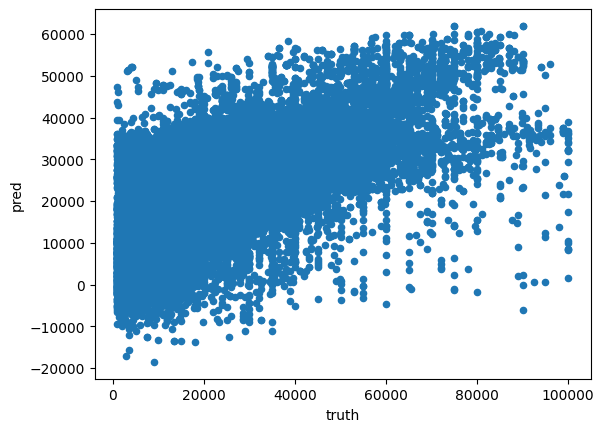

In [49]:
# Check test set predictions. 
predTruth.plot.scatter(x='truth',y='pred')

<Axes: xlabel='truth', ylabel='residual'>

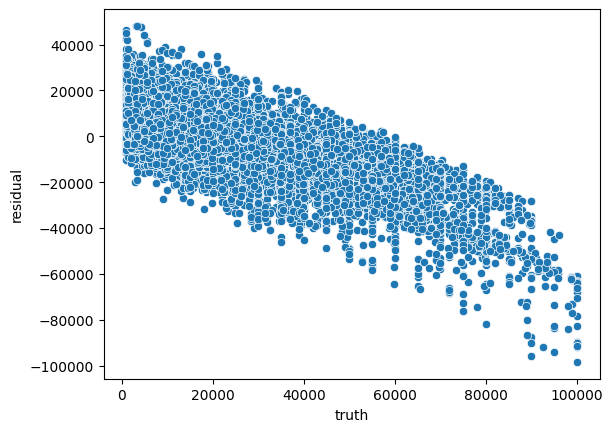

In [50]:
# Residuals are greater at the lower price points, then much smaller
# in the higher price range
sns.scatterplot(predTruth, x='truth', y='residual')

In [193]:
# Analyze coefficients, 74 made it out of the feature transformers
indices = gridSearch.best_estimator_.named_steps['varFilter'].get_support(indices=True)
coefficients = pd.DataFrame({
  'coefficient': gridSearch.best_estimator_.named_steps['preprocess'].get_feature_names_out()[indices],
  'value': gridSearch.best_estimator_.named_steps['regression'].coef_
}).sort_values('value', ascending=False)

display(coefficients.head(15))
display(coefficients.tail(15))

,coefficient,value
70,polynomialfeatures__year^3,16507.872145
67,polynomialfeatures__year^2,6695.836652
69,polynomialfeatures__odometer^2,4811.853816
72,polynomialfeatures__year odometer^2,3883.681574
24,onehotencoder__fuel_diesel,3366.804369
68,polynomialfeatures__year odometer,2891.362395
71,polynomialfeatures__year^2 odometer,2417.625133
20,onehotencoder__manufacturer_ram,1471.616365
9,onehotencoder__manufacturer_gmc,1330.605123
8,onehotencoder__manufacturer_ford,1192.805160


,coefficient,value
58,onehotencoder__state_pa,-359.936706
48,onehotencoder__state_mi,-439.490569
21,onehotencoder__manufacturer_subaru,-442.742132
6,onehotencoder__manufacturer_chrysler,-507.212296
17,onehotencoder__manufacturer_mazda,-563.582796
10,onehotencoder__manufacturer_honda,-571.824454
26,onehotencoder__fuel_hybrid,-661.006772
25,onehotencoder__fuel_gas,-763.392079
19,onehotencoder__manufacturer_nissan,-847.677787
14,onehotencoder__manufacturer_kia,-965.057248


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

I chose lasso linear regression to model this data, and used grid search to find optimal hyperparameters. These included degree of polynomial factors to include, and the penalty size (alpha) of the lasso regression.

In the best resulting model based on cross validation scores (MSE), it estimated car prices about $20 less than actual based on the testing set. I think this shows the model can be useful. All models are wrong, but some are useful.

I did do a significant amount of data cleaning prior to training the model. I do not know the business of the clients here, so I was making decisions to increase the liklihood of creating an accurate model. I'd want to revisit all of these decisions with the client to see if they think I'm dropping features that they think are particularly useful. If so, we can spend more time transforming the data and filling in missing data.

Looking at the greatest and smallest coefficients, we can see the strongest drivers of price in the model. Strangely, year^3 and year^2 are the biggest drivers of price, but year^1 itself is the smallest. Polynomial features can have complex interactions so that must be a factor here. I was also not able to center my data due to sparse matrices errors. I was only able to scale the features, so year and odometer coefficients aren't comparable to the other coefficients.

The next largest drivers are related to the odometer, an odometer * year interaction, and diesel fuel. Manufacturers also have a big impact with Kia, VW, and Hyundai being drags to the price, while Ram, GMC, and Ford drive the price up. It seems these customers appreciate American made cars.

To continue this work, I would run additional feature importance analysis to better understand the drivers of the model.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

#### Introduction
Based on the data set you shared, I used linear regression to build and test many models to predict the price of a car. The objective was to allow you to input several pieces of information (year of the car, fuel type, odometer reading, manufacturer, etc) and the model would predict the price it would sell for. This is based on the data you shared so it will maintain any bias that was in that data set (pricing dynamics related to car information).

#### Results
I ended up with a model that was able to estimate the price of a car that was about $20 off the truth in the training set. This means that with new unseen data, we can expect that the price output will be close to the final price. However, there is a lot of variation in the estimates and there is a chance that the model can produce a number far above or far below the market price.

The top drivers of price are the year, the odometer reading, and fuel types. Manufacturers are also important, especially (Kia, VW, Hyundai, and American-made cars).

#### Usage Guidance
To deploy this model, I would input the necessary information ('region','manufacturer','fuel','title_status','transmission','state', 'year', 'odometer') and the price output as a starting number for the listing. You should sanity check the price (compare against other similar cars), and adjust as you see fit. The market price is always moving and salesmanship also plays a big role, so use this price output as guidance.

#### Next Steps
I would want to walk through all the data cleaning steps I did and make sure I did not make any rash decisions. You know the business better than me and having intuitive sense of what is important will help me build a better model.